# Forecasting Housing Prices 2022 - 2024
 <i> Bushra Islam, Ha Bui, Geeta Apodaca, Ramya Venkatesan, Karthigalakshmi Ramasamy, Elizabeth Hall, and Ewa Godlewska


---



## Set-Up

In [1]:
# to load the housing data drive go to google drive, 
# right click the housing data folder and add shortcut to drive, save in MyDrive

# mount google drive with data folders
from google.colab import drive
drive.mount('/content/drive/')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Data processing
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime,timedelta

# modeling
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from numpy import concatenate
import tensorflow as tf
from pandas import concat
from pandas import DataFrame
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Visualization
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Forecasting based on FED's housing market correction plan




In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# load the data from the drive
df = pd.read_csv ('/content/drive/MyDrive/ds4_housing_data/housing_data_for_modeling_v2.csv')

# set the time to pd datetime format
df['time']=pd.to_datetime(df['time'])
df = df.loc[df['time'] < '2022-06-01']

df_time1_train = df.loc[(df["time"] >= "2005-01-01") & (df["time"]<="2018-12-01")]
df_time1_test = df.loc[df["time"] >= "2019-01-01"]

df_time1_train_raw = df_time1_train
df_time1_test_raw = df_time1_test
df_time1_raw = pd.concat([df_time1_train_raw, df_time1_test_raw])

df_time1_train = df_time1_train.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'],axis=1)
df_time1_test = df_time1_test.drop(['Unnamed: 0', 'housing_price', 'rental_price', 'inflation_rate',
       'property_tax_rate', 'median_age_homebuyers', 'housing_starts',
       'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate',
       'work_home_rate'] ,axis=1)

df_time1 = pd.concat([df_time1_train, df_time1_test])

# load the dataset for sensitvity
dataframe_future = pd.read_csv('/content/drive/MyDrive/ds4_housing_data/forecast30observation_sensitivity_new.csv')

dataframe_future = dataframe_future.drop(["Unnamed: 0"], axis=1)
dataframe_future_combined = pd.concat([df_time1, dataframe_future])
dataframe_future_combined["diff_inflation_rate"] = list(pd.concat([df, dataframe_future])["inflation_rate"].diff().diff())
dataframe_future_combined["diff_inflation_rate"][:2] = 0
dataframe_future_combined["diff_mortgage_to_income_rate"] = list(pd.concat([df, dataframe_future])["mortgage_to_income_rate"].diff().diff())
dataframe_future_combined["diff_mortgage_to_income_rate"][:2] = 0
dataframe_future_combined = dataframe_future_combined.reset_index()
dataframe_future_combined = dataframe_future_combined.drop(["index", "time", "mortgage_to_income_rate",	'inflation_rate'], axis=1)
dataframe_future_combined = dataframe_future_combined.iloc[:239,:] 

#data-row 208: old, datarow209-end: new (predict)
df_forecast = dataframe_future_combined.iloc[:209,:]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


loop through each month make predictions, append to df and make next months prediction

In [4]:
a = [*range(1,32,1)]   

for i in a:
  df_forecast1 = dataframe_future_combined.iloc[:(209+i),:]
  df_forecast_train = df_forecast1.iloc[:-1,:]
  df_forecast_test = df_forecast1.iloc[-30:]
  df_forecast_test_na0 = df_forecast_test.fillna(0)    
  dataset_new = df_forecast_train.to_numpy()

  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_new = scaler.fit_transform(dataset_new)
  
  # frame as supervised learning
  reframed_new = series_to_supervised(scaled_new, 1, 1)
  
  # drop columns we don't want to predict
  reframed_new.drop(reframed_new.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
  values_new = reframed_new.values
  train_size = int(len(df_forecast_train))
  train_new = values_new[0:train_size,:]
  train_X, train_y = train_new[:, :-1], train_new[:, -1]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  dataset_forecast = df_forecast_test_na0.to_numpy()              
  scaled_forecast = scaler.fit_transform(dataset_forecast)
  reframed_forecast = series_to_supervised(scaled_forecast, 1, 1)
  reframed_forecast.drop(reframed_forecast.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
  values_forecast = reframed_forecast.values
  test_size = int(len(df_forecast_test))
  test_new = values_forecast[0:test_size,:]
  test_X, test_y = test_new[:, :-1], test_new[:, -1]
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  model = Sequential()
  model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(train_X, train_y, epochs=40, batch_size=5, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0] 
  dataframe_future_combined.iloc[(208+i):(209+i),0] = inv_yhat[-1]

#save predicted data to cvs so next time don't need to run loop again
dataframe_future_combined.to_csv('/content/drive/MyDrive/ds4_housing_data/dataframe_future_combined.csv')

add in the time to the dataframe of predictions, and add in the forecasting exogenous variables to do the inverse transformation

In [5]:
# concat 2 dataframes to get "time"
dataframe_future["time"] = ['2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01','2023-01-01','2023-02-01','2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01']

df = pd.read_csv ('/content/drive/MyDrive/ds4_housing_data/housing_data_for_modeling_v2.csv')
df_final_forecast = pd.concat([df, dataframe_future], axis=0).reset_index()

df_final_forecast = df_final_forecast[['time','housing_price']].copy()
dataframe_future_forecast = dataframe_future_combined[['diff_housing_price']].copy()

# merge df_final_forecast + dataframe_future_combined 
df2_final_forecast = pd.concat([df_final_forecast,dataframe_future_forecast], axis=1)

inverse the differenced predictions to get the actual house price data

In [ ]:
## Inverse difference to get the actual house price

df_lstm_final_forecast = df2_final_forecast.loc[df2_final_forecast['time'] >= "2022-05-02"]
col = 'housing_price'
df_lstm_final_forecast[str(col)+'_1d'] = (df[col].iloc[-1]-df[col].iloc[-2]) + df_lstm_final_forecast['diff_housing_price'].cumsum()
df_lstm_final_forecast[str(col)+'_LSTM_forecast'] = df[col].iloc[-1] + df_lstm_final_forecast[str(col)+'_1d'].cumsum()
df_lstm_final_forecast["time"] = pd.to_datetime(df_lstm_final_forecast["time"])

plot the forecast!

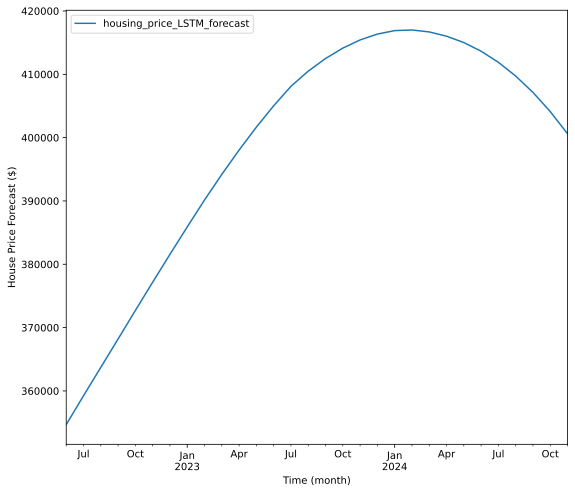

In [7]:
# Plot
df_lstm_final_forecast.plot(x="time", y=["housing_price_LSTM_forecast"], kind="line", figsize=(9, 8))
plt.ylabel("House Price Forecast ($)")
plt.xlabel("Time (month)")
plt.rcParams.update({'axes.facecolor':'lightgrey'})

to plot the forecasts we've already run load in the csv with both forecasts to make the corrected forecast plot!

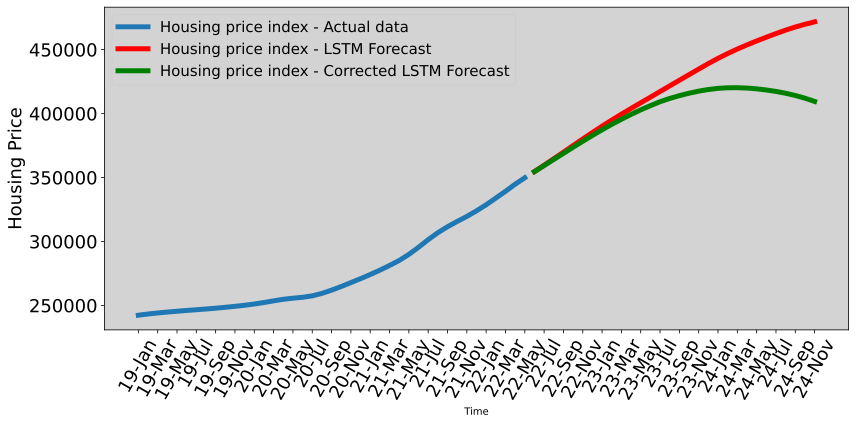

<Figure size 432x288 with 0 Axes>

In [12]:
forecast_final = pd.read_csv('/content/drive/MyDrive/ds4_housing_data/forecast_final.csv')
x = forecast_final.time
y1 = forecast_final.housing_price
y2 = forecast_final.housing_price_LSTM_forecast
y3 = forecast_final.housing_price_corrected_LSTM_forecast
plt.figure(figsize=(12, 6), dpi=600)
plt.plot(x, y1, label='Housing price index - Actual data', linewidth = 5)
plt.plot(x, y2, label='Housing price index - LSTM Forecast', linewidth = 5, color = 'red')
plt.plot(x, y3, label='Housing price index - Corrected LSTM Forecast', linewidth = 5, color = 'green')
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.ylabel('Housing Price', fontsize=18)
plt.xlabel('Time')
plt.xticks(x, rotation=60, fontsize=18)
plt.yticks(fontsize=18)
plt.locator_params(axis='x', nbins=len(x)/2)
plt.legend(prop={'size': 15})
plt.tight_layout()
plt.show()
plt.savefig("forecast1.jpg", transparent=True)